In [1]:
import sys

sys.path.append('../../vollab')

import vollab as lab
import numpy as np

import ito
import functools
import datetime as dt
import matplotlib.pyplot as plt

from dateutil.parser import parse
from scipy import stats

In [2]:
# create market parameters
market_params = lab.MarketParams(spot=50.0, short_rate=0.0)
market_params.__dict__

{'spot': 50.0, 'short_rate': 0.0, 'dividend_yield': 0.0}

In [3]:
# Heston model parameters
heston_model_params = {'nu': 0.04,
                       'nu_bar': 0.04,
                       'eta': 1.0,
                       'lmbda': 10.0,
                       'rho': -1.0}

characteristic_function \
    = lab.create_characteristic_function('Heston')
characteristic_function.__dict__.update(heston_model_params)
heston_model_params

{'nu': 0.04, 'nu_bar': 0.04, 'eta': 1.0, 'lmbda': 10.0, 'rho': -1.0}

In [4]:
# interested in strikes around the spot price
strike_selector = functools.partial(lab.select_strike,
                                    0.7 * market_params.spot,
                                    1.3 * market_params.spot)

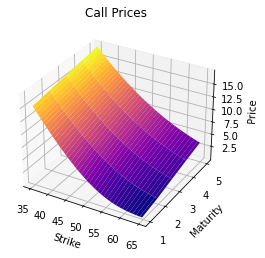

In [5]:
# plot the European call prices as a function of strike and maturity
call_price_strikes, call_price_tenors, call_prices_by_fft \
    = lab.compute_call_prices_matrix( characteristic_function,
                                      market_params,
                                      strike_selector,
                                      [1.0, 2.0, 3.0, 4.0, 5.0])
call_prices_by_fft = np.array(call_prices_by_fft)
lab.plot_surface(call_price_strikes,
                 call_price_tenors,
                 np.transpose(call_prices_by_fft),
                "Call Prices",
                "Strike", "Maturity", "Price")
#plt.savefig('prices.png')

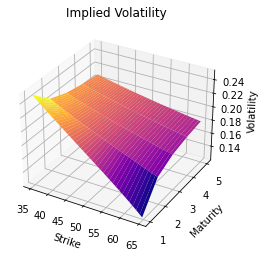

In [6]:
# plot the implied volatility as a function of strike and maturity
iv_strikes, iv_tenors, implied_vol_surface \
    = lab.compute_implied_vol_surface(characteristic_function,
                                         market_params,
                                         strike_selector,
                                         [1.0, 2.0, 3.0, 4.0, 5.0])
lab.plot_surface(iv_strikes, iv_tenors,
                 np.transpose(implied_vol_surface),
                "Implied Volatility",
                "Strike", "Maturity", "Volatility")
#plt.savefig('impliedvol.png')

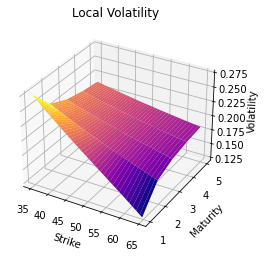

In [7]:
# plot the local volatility as a function of strike and maturity
lv_strikes, lv_tenors, local_vol_surface \
    = lab.compute_local_vol_matrix(characteristic_function,
                                     market_params,
                                     strike_selector,
                                     [1.0, 2.0, 3.0, 4.0, 5.0])
lab.plot_surface(lv_strikes, lv_tenors,
                 np.transpose(local_vol_surface),
                "Local Volatility",
                "Strike", "Maturity", "Volatility")
#plt.savefig('localvol.png')

In [8]:
definition = """
# An example of an exotic product.
#
# See the discussion in, Chapter 10 Exotic Cliquets,
#   The volatility surface: a practitioner's guide, Jim Gatheral.
#
# Mediobanca Bond Protection 2002-2005, ISIN IT0003391353
#
# Locally Capped Globally Floored Cliquet
#
underlying = "STOXX";
#
minCoupon = 0.02;
#
currency = "EUR";
#
notionalAmount = 1.0;
#
get notionalAmount * coupon[1] in currency on couponDates[1];
get notionalAmount * coupon[2] in currency on couponDates[2];
get notionalAmount * coupon[3] in currency on couponDates[3];
#
coupon[c] = max[sumReturns[c], minCoupon];
#
sumReturns[c] = sum[resetReturns[endDates[c], startDates[c]]];
#
resetReturns[{}, {}] = {};
resetReturns[t:ts, tm:tms] = min[max[r[t, tm], -0.01],  0.01] : resetReturns[ts, tms];
#
r[t, tMinus] = performance[s[t], s[tMinus]];
#
performance[st,stMinus] = (st - stMinus) / stMinus;
#
s[t] = Observe[underlying, t];
#
startDates[c] = dropTail[resetDates[c]];
#
endDates[c] = dropHead[resetDates[c]];
#
couponDates[1] = '2002-12-02';
couponDates[2] = '2003-12-02';
couponDates[3] = '2004-12-02';
#
resetDates[1] = {
'2002-01-02',
'2002-01-02',
'2002-02-02',
'2002-03-02',
'2002-04-02',
'2002-05-02',
'2002-06-02',
'2002-07-02',
'2002-08-02',
'2002-09-02',
'2002-10-02',
'2002-11-02',
'2002-11-25'};
#
resetDates[2] = {
'2003-01-02',
'2003-01-02',
'2003-02-02',
'2003-03-02',
'2003-04-02',
'2003-05-02',
'2003-06-02',
'2003-07-02',
'2003-08-02',
'2003-09-02',
'2003-10-02',
'2003-11-02',
'2003-11-25'
};
#
resetDates[3] = {
'2004-01-02',
'2004-01-02',
'2004-02-02',
'2004-03-02',
'2004-04-02',
'2004-05-02',
'2004-06-02',
'2004-07-02',
'2004-08-02',
'2004-09-02',
'2004-10-02',
'2004-11-02',
'2004-11-25'
};
#
# remove the head (first entry) from the list
dropHead[{}] = {};
dropHead[{x}] = {};
dropHead[x:xs] = xs;
# remove the tail (last entry) from the list
dropTail[{}] = {};
dropTail[{x}] = {};
dropTail[x:xs] = x : dropTail[xs];
# minimum of two numbers.
min[x,y] = if x < y then x else y endif;
# maximum of two numbers.
max[x,y] = if x < y then y else x endif;
# sum of a list of numbers
sum[{}] = 0;
sum[{x}] = x;
sum[x:xs] = x + sum[xs];
"""

In [9]:
def merge_iso_date_lists(lhs, rhs):
    return sorted(list(set(lhs + rhs)))


# open the definition in Ito
handle = ito.Handle(definition)

product_dates = merge_iso_date_lists(
    [pd.date for pd in handle.payment_definitions],
    [od.date for od in handle.observation_definitions])

In [10]:
def days_between(todays_date, date):
    d1 = parse(todays_date)
    d2 = parse(date)
    return (d2 - d1).days


def time_between(todays_date, date):
    return days_between(todays_date, date) / 365.0


def compute_pv(mkt_params, sim_dates, sim, hdl):
    start_date = sim_dates[0]
    num_sims = sim.shape[0]
    dfs = np.array([np.exp(-mkt_params.short_rate * time_between(start_date, pd.date))
           for pd in hdl.payment_definitions])

    observation_indices = np.array([sim_dates.index(od.date)
                                    for od in hdl.observation_definitions])

    observations = sim[:, observation_indices].flatten()
    payments = np.array(hdl.compute_payments(num_sims, observations.tolist()))
    payments = payments.reshape((num_sims, handle.num_payments))

    discounted_payments = dfs[np.newaxis, :] * payments
    avg_discounted_payments = np.mean(discounted_payments, axis=0)
    pvs = np.sum(discounted_payments, axis=1)
    pv = np.mean(pvs)
    pv_confidence = 1.96 * stats.sem(pvs, axis=0)
    return pv, pv_confidence, avg_discounted_payments

In [11]:
num_paths = 4096
today = '2002-01-01'

In [12]:
stepping_dates = [dt.date.fromordinal(o).isoformat()
                     for o in range(parse(product_dates[0]).toordinal(),
                                    parse(product_dates[-1]).toordinal(),
                                    5)]

sim_dates = merge_iso_date_lists([today],
                                    merge_iso_date_lists(stepping_dates,
                                                         product_dates))

time_axis = np.array([time_between(today, d) for d in sim_dates])

In [13]:
hs_mc = lab.HestonMonteCarlo(time_axis,
                          num_paths,
                          **heston_model_params)
hs_sim = hs_mc.sample()[0].T

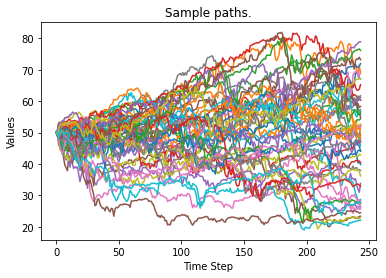

In [49]:
hs_sim.shape
lab.plot_paths(hs_sim[:50,:].T)
#plt.savefig('sample_paths.png');

In [14]:
spline_tenors = [1.0, 2.0, 3.0, 4.0, 5.0]

_, _, _, local_vol_spline_surface \
    = lab.compute_local_vol_spline_surface(characteristic_function,
                                           market_params,
                                           strike_selector,
                                           spline_tenors)

lv_sim \
    = lab.LocalVolMonteCarlo(local_vol_spline_surface,
                             time_axis,
                             num_paths,
                             market_params.spot,
                             market_params.short_rate).sample()[0].T

In [15]:
%%time
hs_pv, hs_cf, hs_average_discounted_payments \
    = compute_pv(market_params,
                 sim_dates,
                 hs_sim,
                 handle)

CPU times: user 6.87 s, sys: 3.82 ms, total: 6.88 s
Wall time: 6.89 s


In [16]:
%%time
lv_pv, lv_cf, lv_average_discounted_payments \
    = compute_pv(market_params,
                 sim_dates,
                 lv_sim,
                 handle)

CPU times: user 6.58 s, sys: 43 µs, total: 6.58 s
Wall time: 6.57 s


In [28]:
print('Monte Carlo results are stated with 95% confidence.')

notional = 1e8
print('\nWith {:,.0f} EUR notional:-\n'.format(1e8))
print('Heston PV    :', "{:,.0f} +/- {:,.0f} EUR".format(notional * hs_pv, notional * hs_cf))
print('Local Vol. PV:', "{:,.0f} +/- {:,.0f} EUR".format(notional *lv_pv, notional *lv_cf) )
print('PV difference:', "{:,.0f} EUR".format(notional * (hs_pv - lv_pv)))

print('\nWith 1 EUR notional:-\n')
print('Heston PV:', "{:.8f} +/- {:.8f}".format(hs_pv, hs_cf))
print('Heston Avg Coupons:', hs_average_discounted_payments)
print('Heston Reference Coupon:', 0.0353)
print('Local Vol. PV:', "{:.8f} +/- {:.8f}".format(lv_pv, lv_cf) )
print('Local Vol. Avg Coupons:', lv_average_discounted_payments)
print('Local Vol. Reference Coupon:', 0.0255)

Monte Carlo results are stated with 95% confidence.

With 100,000,000 EUR notional:-

Heston PV    : 9,933,022 +/- 94,994 EUR
Local Vol. PV: 7,536,137 +/- 61,967 EUR
PV difference: 2,396,885 EUR

With 1 EUR notional:-

Heston PV: 0.09933022 +/- 0.00094994
Heston Avg Coupons: [0.03331829 0.03309263 0.0329193 ]
Heston Reference Coupon: 0.0353
Local Vol. PV: 0.07536137 +/- 0.00061967
Local Vol. Avg Coupons: [0.02572545 0.02484162 0.02479431]
Local Vol. Reference Coupon: 0.0255


In [23]:
%%time
def update_min_coupon(defn, minCoupon):
    new_defn = "minCoupon = {:.2f}".format(minCoupon)
    return defn.replace("minCoupon = 0.02", new_defn);

trial_values = np.linspace(0.01, 0.12, 12)

hs_pvs = []
lv_pvs = []
idx = 0
for trial_min_coupon in trial_values:
    defn = update_min_coupon(definition, trial_min_coupon)
    hdl = ito.Handle(defn)
    hs_trial_pv, _, _ \
        = compute_pv(market_params,
                     sim_dates,
                     hs_sim,
                     hdl)
    hs_pvs.append(hs_trial_pv)
    lv_trial_pv, _, _ \
        = compute_pv(market_params,
                 sim_dates,
                 lv_sim,
                 hdl)
    lv_pvs.append(lv_trial_pv)
    idx += 1

CPU times: user 2min 52s, sys: 56 ms, total: 2min 52s
Wall time: 2min 52s


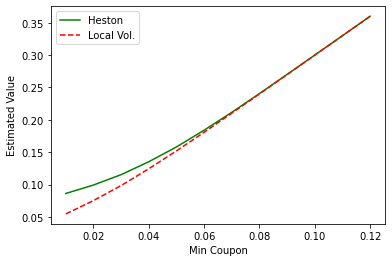

In [44]:
plt.xlabel("Min Coupon")
plt.ylabel("Estimated Value")
plt.plot(trial_values, hs_pvs, 'g-', label="Heston")
plt.plot(trial_values, lv_pvs, 'r--', label="Local Vol.");
plt.legend(loc="upper left")
#plt.savefig('pv_comparison.png');